In [31]:
!git clone http://github.com/Zapy67/ATML-PA-4 test

Cloning into 'test'...
remote: Enumerating objects: 302, done.
remote: Counting objects: 100% (228/228), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 302 (delta 185), reused 157 (delta 117), pack-reused 74 (from 1)
Receiving objects: 100% (302/302), 1.26 MiB | 17.42 MiB/s, done.
Resolving deltas: 100% (211/211), done.


In [178]:
!git pull http://github.com/Zapy67/ATML-PA-4 test

remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 5 (delta 4), reused 5 (delta 4), pack-reused 0 (from 0)
Unpacking objects: 100% (5/5), 1.95 KiB | 124.00 KiB/s, done.
From http://github.com/Zapy67/ATML-PA-4
 * branch            test       -> FETCH_HEAD
Updating 90fa632..5c07e0a
Fast-forward
 fed_lib/fed_methods.py |    5 +-
 task2.ipynb            | 1190 ++++--------------------------------------------
 2 files changed, 100 insertions(+), 1095 deletions(-)


In [ ]:
%cd test

[Errno 2] No such file or directory: 'test'
/kaggle/working/test/test/test


In [ ]:
!ls

'ATML - PA 4.pdf'   fedprox.ipynb       README.md     task4.ipynb
 data		    fedsam.ipynb        task1.ipynb
 fedgh.ipynb	    fedscaffold.ipynb   task2.ipynb
 fed_lib	    LICENSE	        task3.ipynb


#  FedAvg & Local Optimization

In [179]:
import torch
import torch.nn as nn

In [180]:
# !pip install fedlab

In [181]:
import fed_lib
import importlib
importlib.reload(fed_lib)

<module 'fed_lib' from '/kaggle/working/test/test/test/fed_lib/__init__.py'>

In [182]:
from fed_lib import fed_methods, fed_model, utils
importlib.reload(fed_methods)
importlib.reload(fed_model)
importlib.reload(utils)

<module 'fed_lib.utils' from '/kaggle/working/test/test/test/fed_lib/utils.py'>

In [151]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
trainset, testset = utils.get_cifar10()
n_samples = len(trainset)

In [101]:
client_weights = [0.2] * 5
domains = [0.2] * 5

In [102]:
fed = fed_model.Federation(num_clients=5, federate_method=fed_methods.FedSGD(client_weights=client_weights), domains=domains, partition="dirichlet", alpha=10000,device=device, batch_size=64, pin_memory=True, num_workers=2)

In [ ]:
fed.train(50, lr=1e-5, verbose=True)


--- Round 1/50 ---
Training Clients
Training Client 1/5


KeyboardInterrupt: 

In [103]:
import matplotlib.pyplot as plt
def plot_fed_vs_central_acc(metrics, title="FedAvg vs Central Test Accuracy"):
    """
    Args:
        metrics (dict): self.round_metrics dictionary from FedSGD.
    """
    fed_acc = metrics.get('fed_test_acc', [])
    central_acc = metrics.get('central_test_acc', [])

    rounds = list(range(1, len(fed_acc) + 1))

    plt.figure(figsize=(8, 5))
    plt.plot(rounds, fed_acc, marker='o', label='FedAvg (Server) Accuracy')
    plt.plot(rounds, central_acc, marker='s', label='Central Model Accuracy')

    plt.xlabel("Round")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_fed_test_acc(metrics, title="Federated Test Accuracy"):
    fed_acc = metrics.get('fed_test_acc', [])
    rounds = list(range(1, len(fed_acc) + 1))

    plt.figure(figsize=(8, 5))
    plt.plot(rounds, fed_acc, marker='o', label='Fed Test Accuracy')

    plt.xlabel("Round")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_client_drift(metrics, title="Client Drift Over Rounds"):
    drift = metrics.get('client_drift', [])
    rounds = list(range(1, len(drift) + 1))

    plt.figure(figsize=(8, 5))
    plt.plot(rounds, drift, marker='s', label='Client Drift')

    plt.xlabel("Round")
    plt.ylabel("Drift")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [175]:
def fed_avg_exp(lr=1e-3, num_steps=5, num_clients=5, partition="dirichlet", alpha=10000,device=device, global_runs=20, verbose=False, sampling_frac=1.0):
        fed = fed_model.Federation(num_clients=num_clients, federate_method=None, partition=partition, domains=None, alpha=alpha, device=device, batch_size=64, pin_memory=True, num_workers=2)
        client_loaders = fed.client_dataloaders
        client_weights = [len(client.dataset.indices)/len(fed.centralized_train_loader) for client in client_loaders]
        
        fed_meth = fed_methods.FedAvg(local_epochs=1, aggregation_steps=num_steps, client_weights=client_weights, sample_fraction=sampling_frac)
        fed.set_method(fed_meth)
        fed.train(global_runs, lr=lr, verbose=verbose, train_central=False)

        return fed

In [202]:
import matplotlib.pyplot as plt

def plot_metrics(metrics:dict):
    metric_map = {
        'fed_test_acc': 'Test Accuracy',
        'fed_test_loss': 'Test Loss',
        'client_drift': 'Client Drift (Norm)'
    }
    metric_order = ['fed_test_acc', 'fed_test_loss', 'client_drift']
    k_values = sorted(metrics.keys())

    fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
    fig.suptitle('FedAvg Comparison by clients sampled (f)', fontsize=14)


    for i, metric_key in enumerate(metric_order):
        ax = axes[i]
        for k in k_values:
            values = metrics[k][metric_key]
            rounds = list(range(1, len(values) + 1))
            ax.plot(rounds, values, label=f'f={k} Steps')
            
        ax.set_ylabel(metric_map[metric_key])
        ax.grid(axis='y', linestyle='--', alpha=0.6)    
        ax.legend(title='frac (f)', loc='upper left')
            
    axes[-1].set_xlabel('Global Round')
    plt.show()

In [194]:
#experimental setup 1.
from IPython.display import clear_output
import sys
import io
metrics_exp_1 = {}
total_samples = len(trainset.dataset)
for k in [1, 5, 10, 20]: 
    f = fed_avg_exp(lr=1.25e-2, num_clients=5,num_steps=k, global_runs=50, sampling_frac=1.0)
    metrics_exp_1[k] = f.federated_method.round_metrics
    clear_output(wait=True)


--- Round 1/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.872280e-01
Client Drift Std: 1.628844e-03
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :1.849263e-01
Client Number: 0 Drift :1.860791e-01
Client Number: 4 Drift :1.872151e-01
Client Number: 3 Drift :1.883901e-01
Client Number: 2 Drift :1.895296e-01

Evaluate on round 1:


FedAvg  | Test Loss: 1.9292, Test Acc: 29.11%

--- Round 2/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.644595e-01
Client Drift Std: 1.970678e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.610961e-01
Client Number: 3 Drift :1.639216e-01
Client Number: 1 Drift :1.644106e-01
Client Number: 2 Drift :1.663632e-01
Client Number: 4 Drift :1.665063e-01

Evaluate on round 2:


FedAvg  | Test Loss: 1.7466, Test Acc: 35.96%

--- Round 3/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.557493e-01
Client Drift Std: 1.309384e-03
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.540427e-01
Client Number: 2 Drift :1.548571e-01
Client Number: 1 Drift :1.553238e-01
Client Number: 0 Drift :1.570278e-01
Client Number: 4 Drift :1.574952e-01

Evaluate on round 3:


FedAvg  | Test Loss: 1.6701, Test Acc: 38.41%

--- Round 4/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.498599e-01
Client Drift Std: 9.909584e-04
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.483451e-01
Client Number: 3 Drift :1.491998e-01
Client Number: 2 Drift :1.500610e-01
Client Number: 4 Drift :1.505380e-01
Client Number: 1 Drift :1.511558e-01

Evaluate on round 4:


FedAvg  | Test Loss: 1.5909, Test Acc: 41.49%

--- Round 5/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.459901e-01
Client Drift Std: 9.037820e-04
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :1.446035e-01
Client Number: 2 Drift :1.455374e-01
Client Number: 0 Drift :1.461775e-01
Client Number: 4 Drift :1.462885e-01
Client Number: 3 Drift :1.473437e-01

Evaluate on round 5:


FedAvg  | Test Loss: 1.5433, Test Acc: 43.20%

--- Round 6/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.419020e-01
Client Drift Std: 5.784057e-04
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :1.410627e-01
Client Number: 3 Drift :1.413520e-01
Client Number: 4 Drift :1.422519e-01
Client Number: 1 Drift :1.423792e-01
Client Number: 0 Drift :1.424640e-01

Evaluate on round 6:


FedAvg  | Test Loss: 1.4991, Test Acc: 44.39%

--- Round 7/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.401111e-01
Client Drift Std: 9.740996e-04
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :1.387072e-01
Client Number: 2 Drift :1.394215e-01
Client Number: 0 Drift :1.402230e-01
Client Number: 3 Drift :1.407011e-01
Client Number: 1 Drift :1.415029e-01

Evaluate on round 7:


FedAvg  | Test Loss: 1.4672, Test Acc: 45.71%

--- Round 8/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.370360e-01
Client Drift Std: 5.160540e-04
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :1.363010e-01
Client Number: 2 Drift :1.368207e-01
Client Number: 1 Drift :1.370394e-01
Client Number: 0 Drift :1.371240e-01
Client Number: 3 Drift :1.378946e-01

Evaluate on round 8:


FedAvg  | Test Loss: 1.4370, Test Acc: 47.24%

--- Round 9/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.338289e-01
Client Drift Std: 4.606418e-04
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.331866e-01
Client Number: 0 Drift :1.333709e-01
Client Number: 2 Drift :1.341183e-01
Client Number: 1 Drift :1.341194e-01
Client Number: 4 Drift :1.343490e-01

Evaluate on round 9:


FedAvg  | Test Loss: 1.4097, Test Acc: 48.49%

--- Round 10/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.322746e-01
Client Drift Std: 8.483475e-04
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :1.310625e-01
Client Number: 0 Drift :1.318162e-01
Client Number: 4 Drift :1.322155e-01
Client Number: 2 Drift :1.326815e-01
Client Number: 3 Drift :1.335975e-01

Evaluate on round 10:


FedAvg  | Test Loss: 1.3878, Test Acc: 49.10%

--- Round 11/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.299824e-01
Client Drift Std: 1.238982e-03
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.284161e-01
Client Number: 2 Drift :1.293302e-01
Client Number: 0 Drift :1.299167e-01
Client Number: 4 Drift :1.300794e-01
Client Number: 1 Drift :1.321694e-01

Evaluate on round 11:


FedAvg  | Test Loss: 1.3741, Test Acc: 49.94%

--- Round 12/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.303862e-01
Client Drift Std: 6.733140e-04
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :1.293498e-01
Client Number: 0 Drift :1.298498e-01
Client Number: 1 Drift :1.306960e-01
Client Number: 2 Drift :1.309433e-01
Client Number: 3 Drift :1.310923e-01

Evaluate on round 12:


FedAvg  | Test Loss: 1.3533, Test Acc: 50.29%

--- Round 13/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.288441e-01
Client Drift Std: 4.789301e-04
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :1.283639e-01
Client Number: 2 Drift :1.284774e-01
Client Number: 0 Drift :1.285686e-01
Client Number: 1 Drift :1.292104e-01
Client Number: 3 Drift :1.296003e-01

Evaluate on round 13:


FedAvg  | Test Loss: 1.3349, Test Acc: 51.04%

--- Round 14/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.279282e-01
Client Drift Std: 1.226861e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.259742e-01
Client Number: 2 Drift :1.273006e-01
Client Number: 3 Drift :1.279513e-01
Client Number: 4 Drift :1.290666e-01
Client Number: 1 Drift :1.293485e-01

Evaluate on round 14:


FedAvg  | Test Loss: 1.3150, Test Acc: 51.79%

--- Round 15/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.263352e-01
Client Drift Std: 7.836005e-04
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.254803e-01
Client Number: 4 Drift :1.258172e-01
Client Number: 2 Drift :1.259010e-01
Client Number: 3 Drift :1.268851e-01
Client Number: 1 Drift :1.275922e-01

Evaluate on round 15:


FedAvg  | Test Loss: 1.2967, Test Acc: 52.81%

--- Round 16/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.265976e-01
Client Drift Std: 6.517159e-04
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.256314e-01
Client Number: 2 Drift :1.260388e-01
Client Number: 4 Drift :1.268680e-01
Client Number: 3 Drift :1.271314e-01
Client Number: 1 Drift :1.273186e-01

Evaluate on round 16:


FedAvg  | Test Loss: 1.2839, Test Acc: 53.09%

--- Round 17/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.255006e-01
Client Drift Std: 6.710946e-04
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.243047e-01
Client Number: 3 Drift :1.254417e-01
Client Number: 4 Drift :1.255219e-01
Client Number: 2 Drift :1.259492e-01
Client Number: 1 Drift :1.262857e-01

Evaluate on round 17:


FedAvg  | Test Loss: 1.2701, Test Acc: 53.91%

--- Round 18/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.251884e-01
Client Drift Std: 1.831637e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.228722e-01
Client Number: 4 Drift :1.233574e-01
Client Number: 3 Drift :1.256936e-01
Client Number: 2 Drift :1.262449e-01
Client Number: 1 Drift :1.277740e-01

Evaluate on round 18:


FedAvg  | Test Loss: 1.2450, Test Acc: 55.21%

--- Round 19/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.255524e-01
Client Drift Std: 1.060456e-03
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :1.237464e-01
Client Number: 2 Drift :1.253517e-01
Client Number: 0 Drift :1.255078e-01
Client Number: 3 Drift :1.262504e-01
Client Number: 1 Drift :1.269058e-01

Evaluate on round 19:


FedAvg  | Test Loss: 1.2442, Test Acc: 54.75%

--- Round 20/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.249064e-01
Client Drift Std: 6.864929e-04
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :1.241936e-01
Client Number: 0 Drift :1.242033e-01
Client Number: 3 Drift :1.249244e-01
Client Number: 2 Drift :1.251716e-01
Client Number: 1 Drift :1.260392e-01

Evaluate on round 20:


FedAvg  | Test Loss: 1.2176, Test Acc: 56.00%

--- Round 21/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.243779e-01
Client Drift Std: 7.750998e-04
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.233382e-01
Client Number: 3 Drift :1.237774e-01
Client Number: 1 Drift :1.242856e-01
Client Number: 4 Drift :1.250814e-01
Client Number: 2 Drift :1.254069e-01

Evaluate on round 21:


FedAvg  | Test Loss: 1.2105, Test Acc: 56.49%

--- Round 22/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.238283e-01
Client Drift Std: 1.199977e-03
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :1.220644e-01
Client Number: 3 Drift :1.227799e-01
Client Number: 0 Drift :1.243504e-01
Client Number: 2 Drift :1.247572e-01
Client Number: 1 Drift :1.251898e-01

Evaluate on round 22:


FedAvg  | Test Loss: 1.1836, Test Acc: 57.60%

--- Round 23/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.235364e-01
Client Drift Std: 1.043373e-03
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :1.225501e-01
Client Number: 1 Drift :1.228809e-01
Client Number: 2 Drift :1.229962e-01
Client Number: 0 Drift :1.238004e-01
Client Number: 3 Drift :1.254545e-01

Evaluate on round 23:


FedAvg  | Test Loss: 1.1795, Test Acc: 57.66%

--- Round 24/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.230540e-01
Client Drift Std: 1.156193e-03
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :1.218267e-01
Client Number: 0 Drift :1.218727e-01
Client Number: 3 Drift :1.232593e-01
Client Number: 1 Drift :1.233452e-01
Client Number: 4 Drift :1.249659e-01

Evaluate on round 24:


FedAvg  | Test Loss: 1.1626, Test Acc: 58.40%

--- Round 25/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.232906e-01
Client Drift Std: 9.156079e-04
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :1.220617e-01
Client Number: 0 Drift :1.224308e-01
Client Number: 2 Drift :1.234218e-01
Client Number: 1 Drift :1.242032e-01
Client Number: 3 Drift :1.243357e-01

Evaluate on round 25:


FedAvg  | Test Loss: 1.1529, Test Acc: 58.84%

--- Round 26/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.218042e-01
Client Drift Std: 1.402454e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.201560e-01
Client Number: 3 Drift :1.208527e-01
Client Number: 4 Drift :1.217074e-01
Client Number: 2 Drift :1.220197e-01
Client Number: 1 Drift :1.242855e-01

Evaluate on round 26:


FedAvg  | Test Loss: 1.1385, Test Acc: 59.48%

--- Round 27/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.212520e-01
Client Drift Std: 1.736006e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.182284e-01
Client Number: 2 Drift :1.208630e-01
Client Number: 4 Drift :1.217835e-01
Client Number: 3 Drift :1.218734e-01
Client Number: 1 Drift :1.235117e-01

Evaluate on round 27:


FedAvg  | Test Loss: 1.1178, Test Acc: 59.92%

--- Round 28/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.212067e-01
Client Drift Std: 1.486746e-03
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :1.189366e-01
Client Number: 0 Drift :1.209380e-01
Client Number: 3 Drift :1.212682e-01
Client Number: 4 Drift :1.212719e-01
Client Number: 1 Drift :1.236188e-01

Evaluate on round 28:


FedAvg  | Test Loss: 1.1134, Test Acc: 60.08%

--- Round 29/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.214477e-01
Client Drift Std: 4.568707e-04
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.207056e-01
Client Number: 3 Drift :1.211577e-01
Client Number: 2 Drift :1.216738e-01
Client Number: 4 Drift :1.217232e-01
Client Number: 1 Drift :1.219785e-01

Evaluate on round 29:


FedAvg  | Test Loss: 1.1031, Test Acc: 60.45%

--- Round 30/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.209316e-01
Client Drift Std: 1.137994e-03
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :1.187625e-01
Client Number: 2 Drift :1.209111e-01
Client Number: 0 Drift :1.214577e-01
Client Number: 3 Drift :1.215296e-01
Client Number: 1 Drift :1.219971e-01

Evaluate on round 30:


FedAvg  | Test Loss: 1.1215, Test Acc: 59.82%

--- Round 31/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.197080e-01
Client Drift Std: 6.758044e-04
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :1.188602e-01
Client Number: 0 Drift :1.194111e-01
Client Number: 2 Drift :1.194319e-01
Client Number: 3 Drift :1.199761e-01
Client Number: 1 Drift :1.208606e-01

Evaluate on round 31:


FedAvg  | Test Loss: 1.0823, Test Acc: 61.21%

--- Round 32/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.200281e-01
Client Drift Std: 6.780682e-04
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.192826e-01
Client Number: 0 Drift :1.192873e-01
Client Number: 4 Drift :1.201835e-01
Client Number: 2 Drift :1.203168e-01
Client Number: 1 Drift :1.210706e-01

Evaluate on round 32:


FedAvg  | Test Loss: 1.0808, Test Acc: 61.38%

--- Round 33/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.198344e-01
Client Drift Std: 8.723551e-04
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :1.187372e-01
Client Number: 0 Drift :1.190747e-01
Client Number: 3 Drift :1.197509e-01
Client Number: 4 Drift :1.205449e-01
Client Number: 1 Drift :1.210641e-01

Evaluate on round 33:


FedAvg  | Test Loss: 1.0765, Test Acc: 61.44%

--- Round 34/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.194813e-01
Client Drift Std: 1.433820e-03
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.180193e-01
Client Number: 0 Drift :1.186941e-01
Client Number: 1 Drift :1.187949e-01
Client Number: 4 Drift :1.197783e-01
Client Number: 2 Drift :1.221200e-01

Evaluate on round 34:


FedAvg  | Test Loss: 1.0516, Test Acc: 62.56%

--- Round 35/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.196310e-01
Client Drift Std: 6.765406e-04
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :1.189475e-01
Client Number: 3 Drift :1.191619e-01
Client Number: 4 Drift :1.192164e-01
Client Number: 1 Drift :1.200973e-01
Client Number: 0 Drift :1.207319e-01

Evaluate on round 35:


FedAvg  | Test Loss: 1.0544, Test Acc: 62.49%

--- Round 36/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.193510e-01
Client Drift Std: 8.394261e-04
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.185071e-01
Client Number: 0 Drift :1.186100e-01
Client Number: 4 Drift :1.189834e-01
Client Number: 1 Drift :1.199949e-01
Client Number: 2 Drift :1.206595e-01

Evaluate on round 36:


FedAvg  | Test Loss: 1.0366, Test Acc: 62.96%

--- Round 37/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.191879e-01
Client Drift Std: 5.235518e-04
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :1.182861e-01
Client Number: 0 Drift :1.189895e-01
Client Number: 2 Drift :1.193893e-01
Client Number: 4 Drift :1.194460e-01
Client Number: 3 Drift :1.198288e-01

Evaluate on round 37:


FedAvg  | Test Loss: 1.0245, Test Acc: 63.43%

--- Round 38/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.186215e-01
Client Drift Std: 1.532859e-03
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.168433e-01
Client Number: 4 Drift :1.175008e-01
Client Number: 0 Drift :1.180069e-01
Client Number: 1 Drift :1.197537e-01
Client Number: 2 Drift :1.210028e-01

Evaluate on round 38:


FedAvg  | Test Loss: 1.0385, Test Acc: 62.96%

--- Round 39/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.175254e-01
Client Drift Std: 7.972083e-04
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.163526e-01
Client Number: 4 Drift :1.168791e-01
Client Number: 1 Drift :1.177904e-01
Client Number: 3 Drift :1.180711e-01
Client Number: 2 Drift :1.185336e-01

Evaluate on round 39:


FedAvg  | Test Loss: 1.0080, Test Acc: 64.03%

--- Round 40/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.179843e-01
Client Drift Std: 1.641979e-03
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.165037e-01
Client Number: 0 Drift :1.165247e-01
Client Number: 1 Drift :1.178345e-01
Client Number: 2 Drift :1.180528e-01
Client Number: 4 Drift :1.210060e-01

Evaluate on round 40:


FedAvg  | Test Loss: 1.0101, Test Acc: 64.16%

--- Round 41/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.184486e-01
Client Drift Std: 1.050872e-03
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.174454e-01
Client Number: 4 Drift :1.175054e-01
Client Number: 0 Drift :1.183568e-01
Client Number: 2 Drift :1.185903e-01
Client Number: 1 Drift :1.203452e-01

Evaluate on round 41:


FedAvg  | Test Loss: 0.9864, Test Acc: 64.62%

--- Round 42/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.171884e-01
Client Drift Std: 1.276265e-03
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :1.157120e-01
Client Number: 0 Drift :1.158566e-01
Client Number: 2 Drift :1.171569e-01
Client Number: 1 Drift :1.183280e-01
Client Number: 3 Drift :1.188887e-01

Evaluate on round 42:


FedAvg  | Test Loss: 0.9985, Test Acc: 64.36%

--- Round 43/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.185687e-01
Client Drift Std: 1.047673e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.166314e-01
Client Number: 2 Drift :1.184770e-01
Client Number: 1 Drift :1.188450e-01
Client Number: 3 Drift :1.192055e-01
Client Number: 4 Drift :1.196844e-01

Evaluate on round 43:


FedAvg  | Test Loss: 0.9905, Test Acc: 64.57%

--- Round 44/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.166597e-01
Client Drift Std: 1.185071e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.154369e-01
Client Number: 3 Drift :1.162056e-01
Client Number: 2 Drift :1.162662e-01
Client Number: 4 Drift :1.164655e-01
Client Number: 1 Drift :1.189242e-01

Evaluate on round 44:


FedAvg  | Test Loss: 0.9912, Test Acc: 64.50%

--- Round 45/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.176711e-01
Client Drift Std: 8.952999e-04
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.165097e-01
Client Number: 4 Drift :1.170960e-01
Client Number: 2 Drift :1.173358e-01
Client Number: 1 Drift :1.185201e-01
Client Number: 3 Drift :1.188938e-01

Evaluate on round 45:


FedAvg  | Test Loss: 0.9689, Test Acc: 65.10%

--- Round 46/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.164919e-01
Client Drift Std: 1.387300e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.149174e-01
Client Number: 2 Drift :1.159065e-01
Client Number: 3 Drift :1.159290e-01
Client Number: 4 Drift :1.166750e-01
Client Number: 1 Drift :1.190318e-01

Evaluate on round 46:


FedAvg  | Test Loss: 0.9680, Test Acc: 65.05%

--- Round 47/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.162762e-01
Client Drift Std: 1.205672e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.151012e-01
Client Number: 2 Drift :1.156246e-01
Client Number: 4 Drift :1.156714e-01
Client Number: 3 Drift :1.164571e-01
Client Number: 1 Drift :1.185266e-01

Evaluate on round 47:


FedAvg  | Test Loss: 0.9625, Test Acc: 65.54%

--- Round 48/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.162091e-01
Client Drift Std: 8.341329e-04
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.153602e-01
Client Number: 2 Drift :1.157575e-01
Client Number: 4 Drift :1.158046e-01
Client Number: 3 Drift :1.163769e-01
Client Number: 1 Drift :1.177462e-01

Evaluate on round 48:


FedAvg  | Test Loss: 0.9427, Test Acc: 66.49%

--- Round 49/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.163318e-01
Client Drift Std: 1.192242e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :1.140340e-01
Client Number: 2 Drift :1.165563e-01
Client Number: 1 Drift :1.167608e-01
Client Number: 3 Drift :1.168069e-01
Client Number: 4 Drift :1.175011e-01

Evaluate on round 49:


FedAvg  | Test Loss: 0.9621, Test Acc: 65.64%

--- Round 50/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.161903e-01
Client Drift Std: 1.100496e-03
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.151463e-01
Client Number: 0 Drift :1.155235e-01
Client Number: 1 Drift :1.155626e-01
Client Number: 4 Drift :1.165253e-01
Client Number: 2 Drift :1.181940e-01

Evaluate on round 50:


FedAvg  | Test Loss: 0.9260, Test Acc: 67.01%
Training Complete!


FedAvg  | Test Loss: 0.9260, Test Acc: 67.01%


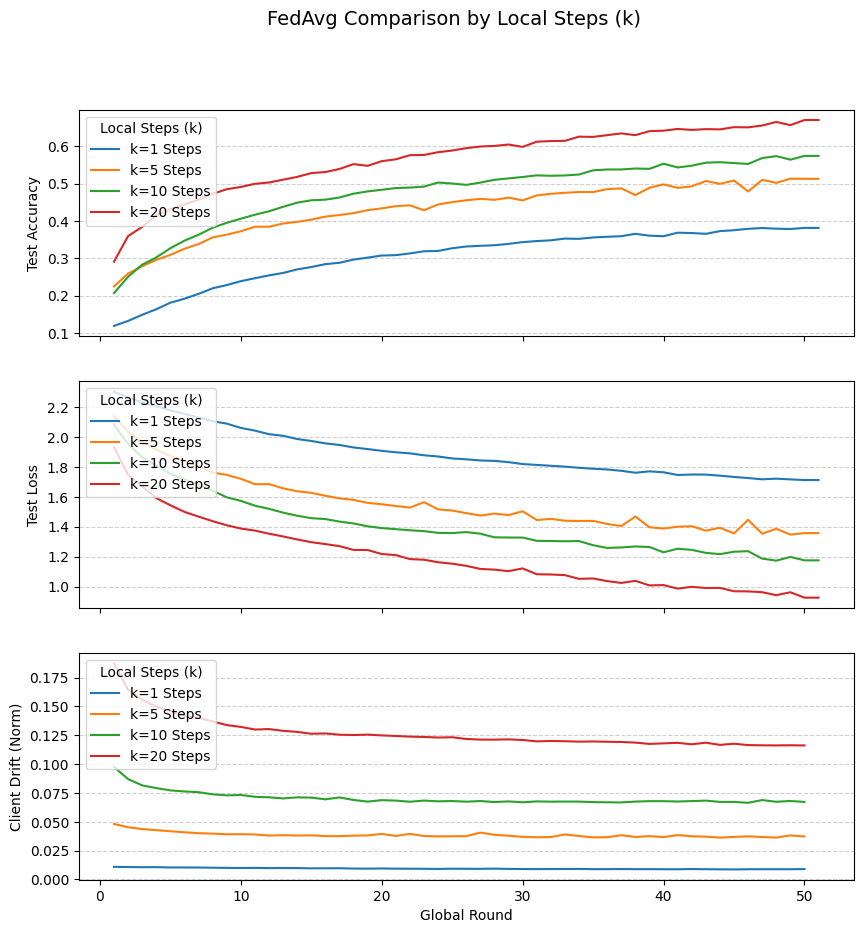

In [195]:
plot_metrics(metrics_exp_1)

In [201]:
#experimental setup 2.
metrics_exp_2 = {}
total_samples = len(trainset.dataset)

for frac in [1.0, 0.5, 0.2]: 
    f = fed_avg_exp(lr=2e-2, num_clients=5, num_steps=5, global_runs=50, sampling_frac=frac)
    metrics_exp_2[frac] = f.federated_method.round_metrics


--- Round 1/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 7.788125e-02
Client Drift Std: 5.674010e-04
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :7.697015e-02
Client Number: 2 Drift :7.760845e-02
Client Number: 0 Drift :7.788180e-02
Client Number: 3 Drift :7.842264e-02
Client Number: 4 Drift :7.852320e-02

Evaluate on round 1:


FedAvg  | Test Loss: 2.1458, Test Acc: 20.28%

--- Round 2/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 7.146422e-02
Client Drift Std: 5.416498e-04
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :7.068869e-02
Client Number: 1 Drift :7.100768e-02
Client Number: 2 Drift :7.156249e-02
Client Number: 0 Drift :7.198269e-02
Client Number: 3 Drift :7.207952e-02

Evaluate on round 2:


FedAvg  | Test Loss: 1.9935, Test Acc: 24.61%

--- Round 3/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.687692e-02
Client Drift Std: 5.399678e-04
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :6.613784e-02
Client Number: 3 Drift :6.641585e-02
Client Number: 0 Drift :6.708333e-02
Client Number: 2 Drift :6.708862e-02
Client Number: 4 Drift :6.765896e-02

Evaluate on round 3:


FedAvg  | Test Loss: 1.9536, Test Acc: 24.80%

--- Round 4/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.435429e-02
Client Drift Std: 6.949198e-04
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :6.322755e-02
Client Number: 0 Drift :6.388988e-02
Client Number: 4 Drift :6.470032e-02
Client Number: 2 Drift :6.484570e-02
Client Number: 3 Drift :6.510803e-02

Evaluate on round 4:


FedAvg  | Test Loss: 1.8917, Test Acc: 27.32%

--- Round 5/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.173605e-02
Client Drift Std: 5.041243e-04
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :6.122301e-02
Client Number: 4 Drift :6.126363e-02
Client Number: 2 Drift :6.151079e-02
Client Number: 1 Drift :6.232315e-02
Client Number: 3 Drift :6.235966e-02

Evaluate on round 5:


FedAvg  | Test Loss: 1.8448, Test Acc: 29.37%

--- Round 6/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.268210e-02
Client Drift Std: 5.428546e-04
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :6.170465e-02
Client Number: 3 Drift :6.264172e-02
Client Number: 0 Drift :6.268376e-02
Client Number: 2 Drift :6.318340e-02
Client Number: 1 Drift :6.319699e-02

Evaluate on round 6:


FedAvg  | Test Loss: 1.8237, Test Acc: 30.90%

--- Round 7/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.140299e-02
Client Drift Std: 6.160868e-04
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :6.096803e-02
Client Number: 0 Drift :6.102327e-02
Client Number: 1 Drift :6.105381e-02
Client Number: 3 Drift :6.136636e-02
Client Number: 4 Drift :6.260347e-02

Evaluate on round 7:


FedAvg  | Test Loss: 1.7880, Test Acc: 32.26%

--- Round 8/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.052198e-02
Client Drift Std: 5.911273e-04
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :5.964990e-02
Client Number: 0 Drift :6.018284e-02
Client Number: 1 Drift :6.057426e-02
Client Number: 3 Drift :6.078738e-02
Client Number: 4 Drift :6.141554e-02

Evaluate on round 8:


FedAvg  | Test Loss: 1.7562, Test Acc: 33.72%

--- Round 9/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.134754e-02
Client Drift Std: 6.807607e-04
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :6.038157e-02
Client Number: 1 Drift :6.087951e-02
Client Number: 0 Drift :6.130574e-02
Client Number: 3 Drift :6.189264e-02
Client Number: 4 Drift :6.227821e-02

Evaluate on round 9:


FedAvg  | Test Loss: 1.7146, Test Acc: 35.83%

--- Round 10/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.079673e-02
Client Drift Std: 2.170146e-03
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :5.916391e-02
Client Number: 3 Drift :5.947819e-02
Client Number: 4 Drift :5.996999e-02
Client Number: 1 Drift :6.030642e-02
Client Number: 0 Drift :6.506512e-02

Evaluate on round 10:


FedAvg  | Test Loss: 1.6724, Test Acc: 37.34%

--- Round 11/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.056880e-02
Client Drift Std: 1.433442e-03
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :5.851613e-02
Client Number: 0 Drift :5.918502e-02
Client Number: 2 Drift :6.134103e-02
Client Number: 1 Drift :6.189390e-02
Client Number: 4 Drift :6.190793e-02

Evaluate on round 11:


FedAvg  | Test Loss: 1.6522, Test Acc: 37.98%

--- Round 12/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 5.986811e-02
Client Drift Std: 1.071103e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :5.834289e-02
Client Number: 1 Drift :5.904327e-02
Client Number: 2 Drift :5.990680e-02
Client Number: 3 Drift :6.085511e-02
Client Number: 4 Drift :6.119248e-02

Evaluate on round 12:


FedAvg  | Test Loss: 1.6600, Test Acc: 38.42%

--- Round 13/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 5.836002e-02
Client Drift Std: 5.013956e-04
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :5.771187e-02
Client Number: 0 Drift :5.791758e-02
Client Number: 3 Drift :5.849169e-02
Client Number: 2 Drift :5.855306e-02
Client Number: 1 Drift :5.912588e-02

Evaluate on round 13:


FedAvg  | Test Loss: 1.6114, Test Acc: 39.83%

--- Round 14/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 5.792357e-02
Client Drift Std: 9.903023e-04
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :5.710576e-02
Client Number: 1 Drift :5.714871e-02
Client Number: 2 Drift :5.729019e-02
Client Number: 3 Drift :5.842200e-02
Client Number: 0 Drift :5.965119e-02

Evaluate on round 14:


FedAvg  | Test Loss: 1.6419, Test Acc: 39.01%

--- Round 15/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 5.786766e-02
Client Drift Std: 1.088961e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :5.632335e-02
Client Number: 4 Drift :5.719814e-02
Client Number: 3 Drift :5.782796e-02
Client Number: 1 Drift :5.846750e-02
Client Number: 2 Drift :5.952133e-02

Evaluate on round 15:


FedAvg  | Test Loss: 1.5880, Test Acc: 41.18%

--- Round 16/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 5.688548e-02
Client Drift Std: 6.861911e-04
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :5.604204e-02
Client Number: 4 Drift :5.610084e-02
Client Number: 2 Drift :5.721998e-02
Client Number: 1 Drift :5.733396e-02
Client Number: 3 Drift :5.773060e-02

Evaluate on round 16:


FedAvg  | Test Loss: 1.5960, Test Acc: 41.13%

--- Round 17/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 5.554483e-02
Client Drift Std: 3.986991e-04
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :5.512156e-02
Client Number: 0 Drift :5.535776e-02
Client Number: 4 Drift :5.539740e-02
Client Number: 3 Drift :5.555509e-02
Client Number: 1 Drift :5.629237e-02

Evaluate on round 17:


FedAvg  | Test Loss: 1.5552, Test Acc: 42.56%

--- Round 18/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 5.957005e-02
Client Drift Std: 2.364783e-03
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :5.683702e-02
Client Number: 2 Drift :5.779572e-02
Client Number: 0 Drift :5.857548e-02
Client Number: 4 Drift :6.154047e-02
Client Number: 1 Drift :6.310157e-02

Evaluate on round 18:


FedAvg  | Test Loss: 1.5668, Test Acc: 42.36%

--- Round 19/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 5.737172e-02
Client Drift Std: 4.905802e-04
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :5.652266e-02
Client Number: 0 Drift :5.721502e-02
Client Number: 3 Drift :5.748439e-02
Client Number: 1 Drift :5.766597e-02
Client Number: 2 Drift :5.797056e-02

Evaluate on round 19:


FedAvg  | Test Loss: 1.5435, Test Acc: 43.32%

--- Round 20/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 5.774895e-02
Client Drift Std: 1.192301e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :5.619152e-02
Client Number: 4 Drift :5.712296e-02
Client Number: 3 Drift :5.741528e-02
Client Number: 2 Drift :5.829646e-02
Client Number: 1 Drift :5.971856e-02

Evaluate on round 20:


FedAvg  | Test Loss: 1.5177, Test Acc: 43.52%

--- Round 21/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 5.769763e-02
Client Drift Std: 1.590116e-03
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :5.550189e-02
Client Number: 0 Drift :5.659553e-02
Client Number: 2 Drift :5.744616e-02
Client Number: 3 Drift :5.912275e-02
Client Number: 4 Drift :5.982183e-02

Evaluate on round 21:


FedAvg  | Test Loss: 1.5072, Test Acc: 44.88%

--- Round 22/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 5.766490e-02
Client Drift Std: 1.950943e-03
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :5.584355e-02
Client Number: 4 Drift :5.636289e-02
Client Number: 1 Drift :5.640981e-02
Client Number: 0 Drift :5.865882e-02
Client Number: 2 Drift :6.104945e-02

Evaluate on round 22:


FedAvg  | Test Loss: 1.5411, Test Acc: 42.91%

--- Round 23/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 5.650694e-02
Client Drift Std: 1.204265e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :5.436205e-02
Client Number: 4 Drift :5.618223e-02
Client Number: 2 Drift :5.675186e-02
Client Number: 1 Drift :5.754638e-02
Client Number: 3 Drift :5.769220e-02

Evaluate on round 23:


FedAvg  | Test Loss: 1.4921, Test Acc: 45.58%

--- Round 24/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 5.841913e-02
Client Drift Std: 3.028441e-03
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :5.409281e-02
Client Number: 1 Drift :5.705553e-02
Client Number: 3 Drift :5.873150e-02
Client Number: 0 Drift :5.879227e-02
Client Number: 2 Drift :6.342353e-02

Evaluate on round 24:


FedAvg  | Test Loss: 1.4879, Test Acc: 45.33%

--- Round 25/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 5.682480e-02
Client Drift Std: 1.134350e-03
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :5.528595e-02
Client Number: 4 Drift :5.620657e-02
Client Number: 0 Drift :5.690042e-02
Client Number: 1 Drift :5.699619e-02
Client Number: 3 Drift :5.873488e-02

Evaluate on round 25:


FedAvg  | Test Loss: 1.4637, Test Acc: 47.47%

--- Round 26/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 5.635301e-02
Client Drift Std: 7.239419e-04
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :5.531292e-02
Client Number: 3 Drift :5.594767e-02
Client Number: 1 Drift :5.616318e-02
Client Number: 4 Drift :5.714503e-02
Client Number: 0 Drift :5.719624e-02

Evaluate on round 26:


FedAvg  | Test Loss: 1.5233, Test Acc: 44.70%

--- Round 27/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 5.597132e-02
Client Drift Std: 1.369845e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :5.459689e-02
Client Number: 2 Drift :5.508504e-02
Client Number: 3 Drift :5.523178e-02
Client Number: 1 Drift :5.656036e-02
Client Number: 4 Drift :5.838253e-02

Evaluate on round 27:


FedAvg  | Test Loss: 1.4499, Test Acc: 46.86%

--- Round 28/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 5.688960e-02
Client Drift Std: 2.694235e-03
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :5.367384e-02
Client Number: 0 Drift :5.444620e-02
Client Number: 1 Drift :5.650970e-02
Client Number: 3 Drift :5.901371e-02
Client Number: 2 Drift :6.080458e-02

Evaluate on round 28:


FedAvg  | Test Loss: 1.4703, Test Acc: 46.33%

--- Round 29/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 5.551436e-02
Client Drift Std: 1.200234e-03
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :5.359691e-02
Client Number: 3 Drift :5.479010e-02
Client Number: 4 Drift :5.579098e-02
Client Number: 0 Drift :5.644356e-02
Client Number: 1 Drift :5.695023e-02

Evaluate on round 29:


FedAvg  | Test Loss: 1.4859, Test Acc: 45.84%

--- Round 30/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 5.753287e-02
Client Drift Std: 3.117177e-03
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :5.312790e-02
Client Number: 2 Drift :5.489212e-02
Client Number: 4 Drift :5.796867e-02
Client Number: 1 Drift :6.054523e-02
Client Number: 0 Drift :6.113042e-02

Evaluate on round 30:


FedAvg  | Test Loss: 1.4313, Test Acc: 48.74%

--- Round 31/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 5.536160e-02
Client Drift Std: 1.706054e-03
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :5.325068e-02
Client Number: 0 Drift :5.407887e-02
Client Number: 1 Drift :5.518970e-02
Client Number: 3 Drift :5.612810e-02
Client Number: 4 Drift :5.816064e-02

Evaluate on round 31:


FedAvg  | Test Loss: 1.5152, Test Acc: 44.29%

--- Round 32/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 5.480874e-02
Client Drift Std: 1.086980e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :5.331346e-02
Client Number: 2 Drift :5.365587e-02
Client Number: 4 Drift :5.563358e-02
Client Number: 1 Drift :5.571596e-02
Client Number: 3 Drift :5.572484e-02

Evaluate on round 32:


FedAvg  | Test Loss: 1.4146, Test Acc: 48.59%

--- Round 33/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 5.617674e-02
Client Drift Std: 1.917326e-03
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :5.372075e-02
Client Number: 3 Drift :5.399049e-02
Client Number: 0 Drift :5.722384e-02
Client Number: 4 Drift :5.790318e-02
Client Number: 1 Drift :5.804545e-02

Evaluate on round 33:


FedAvg  | Test Loss: 1.4560, Test Acc: 47.19%

--- Round 34/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 5.600243e-02
Client Drift Std: 1.813272e-03
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :5.392884e-02
Client Number: 4 Drift :5.451032e-02
Client Number: 1 Drift :5.560256e-02
Client Number: 2 Drift :5.701290e-02
Client Number: 0 Drift :5.895754e-02

Evaluate on round 34:


FedAvg  | Test Loss: 1.4104, Test Acc: 48.94%

--- Round 35/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 5.504341e-02
Client Drift Std: 1.651191e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :5.231599e-02
Client Number: 2 Drift :5.459294e-02
Client Number: 4 Drift :5.488014e-02
Client Number: 1 Drift :5.627692e-02
Client Number: 3 Drift :5.715107e-02

Evaluate on round 35:


FedAvg  | Test Loss: 1.4694, Test Acc: 47.73%

--- Round 36/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 5.673457e-02
Client Drift Std: 1.572258e-03
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :5.522783e-02
Client Number: 0 Drift :5.554337e-02
Client Number: 3 Drift :5.563468e-02
Client Number: 2 Drift :5.828040e-02
Client Number: 1 Drift :5.898655e-02

Evaluate on round 36:


FedAvg  | Test Loss: 1.4052, Test Acc: 49.63%

--- Round 37/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 5.573097e-02
Client Drift Std: 2.125032e-03
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :5.325757e-02
Client Number: 2 Drift :5.414731e-02
Client Number: 4 Drift :5.494902e-02
Client Number: 3 Drift :5.724673e-02
Client Number: 0 Drift :5.905424e-02

Evaluate on round 37:


FedAvg  | Test Loss: 1.5068, Test Acc: 45.59%

--- Round 38/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 5.437529e-02
Client Drift Std: 1.205286e-03
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :5.216334e-02
Client Number: 4 Drift :5.411918e-02
Client Number: 3 Drift :5.478626e-02
Client Number: 1 Drift :5.530229e-02
Client Number: 0 Drift :5.550535e-02

Evaluate on round 38:


FedAvg  | Test Loss: 1.3992, Test Acc: 49.52%

--- Round 39/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 5.535443e-02
Client Drift Std: 7.745420e-04
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :5.445093e-02
Client Number: 1 Drift :5.464058e-02
Client Number: 0 Drift :5.538667e-02
Client Number: 3 Drift :5.569068e-02
Client Number: 2 Drift :5.660326e-02

Evaluate on round 39:


FedAvg  | Test Loss: 1.4346, Test Acc: 48.30%

--- Round 40/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 5.397967e-02
Client Drift Std: 5.327939e-04
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :5.302792e-02
Client Number: 2 Drift :5.378280e-02
Client Number: 0 Drift :5.421028e-02
Client Number: 3 Drift :5.442888e-02
Client Number: 1 Drift :5.444849e-02

Evaluate on round 40:


FedAvg  | Test Loss: 1.3770, Test Acc: 50.37%

--- Round 41/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 5.356347e-02
Client Drift Std: 1.163507e-03
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :5.172092e-02
Client Number: 4 Drift :5.295426e-02
Client Number: 1 Drift :5.358258e-02
Client Number: 0 Drift :5.463254e-02
Client Number: 2 Drift :5.492705e-02

Evaluate on round 41:


FedAvg  | Test Loss: 1.4452, Test Acc: 47.54%

--- Round 42/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 5.529546e-02
Client Drift Std: 3.157974e-03
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :5.240867e-02
Client Number: 0 Drift :5.361068e-02
Client Number: 1 Drift :5.446633e-02
Client Number: 4 Drift :5.457379e-02
Client Number: 2 Drift :6.141785e-02

Evaluate on round 42:


FedAvg  | Test Loss: 1.3583, Test Acc: 51.48%

--- Round 43/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 5.430163e-02
Client Drift Std: 1.325739e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :5.306565e-02
Client Number: 1 Drift :5.319110e-02
Client Number: 4 Drift :5.357005e-02
Client Number: 2 Drift :5.522652e-02
Client Number: 3 Drift :5.645485e-02

Evaluate on round 43:


FedAvg  | Test Loss: 1.4328, Test Acc: 48.56%

--- Round 44/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 5.423318e-02
Client Drift Std: 1.765584e-03
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :5.177413e-02
Client Number: 4 Drift :5.366820e-02
Client Number: 1 Drift :5.379139e-02
Client Number: 0 Drift :5.473749e-02
Client Number: 2 Drift :5.719473e-02

Evaluate on round 44:


FedAvg  | Test Loss: 1.3696, Test Acc: 50.98%

--- Round 45/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 5.394862e-02
Client Drift Std: 1.710719e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :5.245194e-02
Client Number: 2 Drift :5.245437e-02
Client Number: 3 Drift :5.328246e-02
Client Number: 1 Drift :5.454653e-02
Client Number: 4 Drift :5.700782e-02

Evaluate on round 45:


FedAvg  | Test Loss: 1.3547, Test Acc: 51.23%

--- Round 46/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 5.475090e-02
Client Drift Std: 1.050875e-03
Top 5 Clients with Greatest Drift
Client Number: 0 Drift :5.340198e-02
Client Number: 2 Drift :5.367224e-02
Client Number: 4 Drift :5.495385e-02
Client Number: 1 Drift :5.575623e-02
Client Number: 3 Drift :5.597021e-02

Evaluate on round 46:


FedAvg  | Test Loss: 1.4096, Test Acc: 49.93%

--- Round 47/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 5.423420e-02
Client Drift Std: 8.183192e-04
Top 5 Clients with Greatest Drift
Client Number: 4 Drift :5.326244e-02
Client Number: 2 Drift :5.330712e-02
Client Number: 1 Drift :5.439061e-02
Client Number: 3 Drift :5.507447e-02
Client Number: 0 Drift :5.513638e-02

Evaluate on round 47:


FedAvg  | Test Loss: 1.3285, Test Acc: 52.00%

--- Round 48/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 5.839667e-02
Client Drift Std: 1.739823e-03
Top 5 Clients with Greatest Drift
Client Number: 2 Drift :5.620596e-02
Client Number: 0 Drift :5.734603e-02
Client Number: 4 Drift :5.815142e-02
Client Number: 1 Drift :5.889625e-02
Client Number: 3 Drift :6.138366e-02

Evaluate on round 48:


FedAvg  | Test Loss: 1.3517, Test Acc: 52.00%

--- Round 49/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 5.539232e-02
Client Drift Std: 1.691302e-03
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :5.310224e-02
Client Number: 1 Drift :5.451795e-02
Client Number: 4 Drift :5.463417e-02
Client Number: 2 Drift :5.724110e-02
Client Number: 0 Drift :5.746614e-02

Evaluate on round 49:


FedAvg  | Test Loss: 1.3731, Test Acc: 50.72%

--- Round 50/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Client 1/5 for 1 epochs
Training Client 2/5 for 1 epochs
Training Client 3/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 5.456039e-02
Client Drift Std: 1.560078e-03
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :5.276937e-02
Client Number: 2 Drift :5.370444e-02
Client Number: 4 Drift :5.406579e-02
Client Number: 0 Drift :5.489635e-02
Client Number: 1 Drift :5.736598e-02

Evaluate on round 50:


FedAvg  | Test Loss: 1.3616, Test Acc: 51.29%
Training Complete!


FedAvg  | Test Loss: 1.3616, Test Acc: 51.29%

--- Round 1/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.176413e+01
Client Drift Std: 1.691971e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :9.691929e+00
Client Number: 4 Drift :9.692161e+00
Client Number: 1 Drift :1.310956e+01
Client Number: 2 Drift :1.315956e+01
Client Number: 0 Drift :1.316746e+01

Evaluate on round 1:


FedAvg  | Test Loss: 2.3028, Test Acc: 10.00%

--- Round 2/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 8.590968e+00
Client Drift Std: 3.841778e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :3.885825e+00
Client Number: 4 Drift :3.885855e+00
Client Number: 1 Drift :1.168943e+01
Client Number: 2 Drift :1.174585e+01
Client Number: 0 Drift :1.174789e+01

Evaluate on round 2:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 3/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 7.514439e+00
Client Drift Std: 4.861317e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.560465e+00
Client Number: 4 Drift :1.560779e+00
Client Number: 1 Drift :1.144535e+01
Client Number: 0 Drift :1.150246e+01
Client Number: 2 Drift :1.150314e+01

Evaluate on round 3:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 4/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 7.120488e+00
Client Drift Std: 5.295242e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :6.348515e-01
Client Number: 4 Drift :6.355854e-01
Client Number: 1 Drift :1.140591e+01
Client Number: 0 Drift :1.146213e+01
Client Number: 2 Drift :1.146397e+01

Evaluate on round 4:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 5/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.974773e+00
Client Drift Std: 5.465927e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :2.797579e-01
Client Number: 4 Drift :2.811542e-01
Client Number: 1 Drift :1.139967e+01
Client Number: 0 Drift :1.145556e+01
Client Number: 2 Drift :1.145771e+01

Evaluate on round 5:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 6/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.928255e+00
Client Drift Std: 5.521672e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.647602e-01
Client Number: 4 Drift :1.665666e-01
Client Number: 1 Drift :1.139878e+01
Client Number: 0 Drift :1.145448e+01
Client Number: 2 Drift :1.145669e+01

Evaluate on round 6:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 7/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.917766e+00
Client Drift Std: 5.534328e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.376149e-01
Client Number: 4 Drift :1.417348e-01
Client Number: 1 Drift :1.139868e+01
Client Number: 0 Drift :1.145428e+01
Client Number: 2 Drift :1.145652e+01

Evaluate on round 7:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 8/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.916500e+00
Client Drift Std: 5.535858e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.356115e-01
Client Number: 4 Drift :1.374557e-01
Client Number: 1 Drift :1.139868e+01
Client Number: 0 Drift :1.145426e+01
Client Number: 2 Drift :1.145649e+01

Evaluate on round 8:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 9/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.916582e+00
Client Drift Std: 5.535758e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.365497e-01
Client Number: 4 Drift :1.369271e-01
Client Number: 1 Drift :1.139873e+01
Client Number: 0 Drift :1.145428e+01
Client Number: 2 Drift :1.145643e+01

Evaluate on round 9:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 10/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.916430e+00
Client Drift Std: 5.535943e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.349329e-01
Client Number: 4 Drift :1.377864e-01
Client Number: 1 Drift :1.139873e+01
Client Number: 0 Drift :1.145422e+01
Client Number: 2 Drift :1.145648e+01

Evaluate on round 10:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 11/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.916684e+00
Client Drift Std: 5.535635e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.350630e-01
Client Number: 4 Drift :1.389177e-01
Client Number: 1 Drift :1.139871e+01
Client Number: 0 Drift :1.145426e+01
Client Number: 2 Drift :1.145647e+01

Evaluate on round 11:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 12/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.917068e+00
Client Drift Std: 5.535171e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.356775e-01
Client Number: 4 Drift :1.402071e-01
Client Number: 1 Drift :1.139873e+01
Client Number: 0 Drift :1.145433e+01
Client Number: 2 Drift :1.145639e+01

Evaluate on round 12:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 13/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.916967e+00
Client Drift Std: 5.535293e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.358713e-01
Client Number: 4 Drift :1.395143e-01
Client Number: 1 Drift :1.139873e+01
Client Number: 0 Drift :1.145434e+01
Client Number: 2 Drift :1.145638e+01

Evaluate on round 13:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 14/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.917185e+00
Client Drift Std: 5.535030e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.371484e-01
Client Number: 4 Drift :1.393174e-01
Client Number: 1 Drift :1.139870e+01
Client Number: 0 Drift :1.145435e+01
Client Number: 2 Drift :1.145641e+01

Evaluate on round 14:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 15/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.916964e+00
Client Drift Std: 5.535296e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.370406e-01
Client Number: 4 Drift :1.383316e-01
Client Number: 1 Drift :1.139869e+01
Client Number: 0 Drift :1.145429e+01
Client Number: 2 Drift :1.145648e+01

Evaluate on round 15:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 16/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.917154e+00
Client Drift Std: 5.535067e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.362942e-01
Client Number: 4 Drift :1.400185e-01
Client Number: 1 Drift :1.139869e+01
Client Number: 0 Drift :1.145436e+01
Client Number: 2 Drift :1.145641e+01

Evaluate on round 16:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 17/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.916873e+00
Client Drift Std: 5.535407e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.361658e-01
Client Number: 4 Drift :1.387534e-01
Client Number: 1 Drift :1.139873e+01
Client Number: 0 Drift :1.145433e+01
Client Number: 2 Drift :1.145639e+01

Evaluate on round 17:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 18/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.917191e+00
Client Drift Std: 5.535022e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.360125e-01
Client Number: 4 Drift :1.404845e-01
Client Number: 1 Drift :1.139867e+01
Client Number: 0 Drift :1.145436e+01
Client Number: 2 Drift :1.145642e+01

Evaluate on round 18:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 19/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.916993e+00
Client Drift Std: 5.535261e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.367401e-01
Client Number: 4 Drift :1.387770e-01
Client Number: 1 Drift :1.139865e+01
Client Number: 0 Drift :1.145438e+01
Client Number: 2 Drift :1.145643e+01

Evaluate on round 19:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 20/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.917145e+00
Client Drift Std: 5.535078e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.369573e-01
Client Number: 4 Drift :1.393110e-01
Client Number: 1 Drift :1.139867e+01
Client Number: 0 Drift :1.145435e+01
Client Number: 2 Drift :1.145644e+01

Evaluate on round 20:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 21/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.917341e+00
Client Drift Std: 5.534842e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.367699e-01
Client Number: 4 Drift :1.404683e-01
Client Number: 1 Drift :1.139873e+01
Client Number: 0 Drift :1.145437e+01
Client Number: 2 Drift :1.145636e+01

Evaluate on round 21:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 22/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.917262e+00
Client Drift Std: 5.534938e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.369153e-01
Client Number: 4 Drift :1.399309e-01
Client Number: 1 Drift :1.139873e+01
Client Number: 0 Drift :1.145437e+01
Client Number: 2 Drift :1.145636e+01

Evaluate on round 22:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 23/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.917069e+00
Client Drift Std: 5.535169e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.364795e-01
Client Number: 4 Drift :1.394125e-01
Client Number: 1 Drift :1.139874e+01
Client Number: 0 Drift :1.145434e+01
Client Number: 2 Drift :1.145637e+01

Evaluate on round 23:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 24/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.917067e+00
Client Drift Std: 5.535173e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.365106e-01
Client Number: 4 Drift :1.393687e-01
Client Number: 1 Drift :1.139866e+01
Client Number: 0 Drift :1.145441e+01
Client Number: 2 Drift :1.145639e+01

Evaluate on round 24:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 25/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.917302e+00
Client Drift Std: 5.534888e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.367017e-01
Client Number: 4 Drift :1.403473e-01
Client Number: 1 Drift :1.139873e+01
Client Number: 0 Drift :1.145438e+01
Client Number: 2 Drift :1.145635e+01

Evaluate on round 25:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 26/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.917013e+00
Client Drift Std: 5.535239e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.366463e-01
Client Number: 4 Drift :1.389634e-01
Client Number: 1 Drift :1.139877e+01
Client Number: 0 Drift :1.145437e+01
Client Number: 2 Drift :1.145632e+01

Evaluate on round 26:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 27/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.917356e+00
Client Drift Std: 5.534823e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.375193e-01
Client Number: 4 Drift :1.397959e-01
Client Number: 1 Drift :1.139872e+01
Client Number: 0 Drift :1.145440e+01
Client Number: 2 Drift :1.145635e+01

Evaluate on round 27:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 28/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.917620e+00
Client Drift Std: 5.534504e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.364991e-01
Client Number: 4 Drift :1.421261e-01
Client Number: 1 Drift :1.139870e+01
Client Number: 0 Drift :1.145442e+01
Client Number: 2 Drift :1.145635e+01

Evaluate on round 28:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 29/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.917366e+00
Client Drift Std: 5.534810e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.371284e-01
Client Number: 4 Drift :1.402382e-01
Client Number: 1 Drift :1.139868e+01
Client Number: 0 Drift :1.145438e+01
Client Number: 2 Drift :1.145640e+01

Evaluate on round 29:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 30/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.917312e+00
Client Drift Std: 5.534877e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.375196e-01
Client Number: 4 Drift :1.395744e-01
Client Number: 1 Drift :1.139869e+01
Client Number: 0 Drift :1.145440e+01
Client Number: 2 Drift :1.145637e+01

Evaluate on round 30:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 31/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.917336e+00
Client Drift Std: 5.534847e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.365576e-01
Client Number: 4 Drift :1.406588e-01
Client Number: 1 Drift :1.139871e+01
Client Number: 0 Drift :1.145435e+01
Client Number: 2 Drift :1.145641e+01

Evaluate on round 31:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 32/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.917343e+00
Client Drift Std: 5.534839e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.384045e-01
Client Number: 4 Drift :1.388445e-01
Client Number: 1 Drift :1.139870e+01
Client Number: 0 Drift :1.145436e+01
Client Number: 2 Drift :1.145640e+01

Evaluate on round 32:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 33/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.917405e+00
Client Drift Std: 5.534765e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.375054e-01
Client Number: 4 Drift :1.400480e-01
Client Number: 1 Drift :1.139869e+01
Client Number: 0 Drift :1.145435e+01
Client Number: 2 Drift :1.145643e+01

Evaluate on round 33:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 34/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.917329e+00
Client Drift Std: 5.534855e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.361859e-01
Client Number: 4 Drift :1.409973e-01
Client Number: 1 Drift :1.139874e+01
Client Number: 0 Drift :1.145438e+01
Client Number: 2 Drift :1.145635e+01

Evaluate on round 34:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 35/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.917426e+00
Client Drift Std: 5.534739e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.384196e-01
Client Number: 4 Drift :1.392391e-01
Client Number: 1 Drift :1.139869e+01
Client Number: 0 Drift :1.145441e+01
Client Number: 2 Drift :1.145636e+01

Evaluate on round 35:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 36/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.917300e+00
Client Drift Std: 5.534889e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.372080e-01
Client Number: 4 Drift :1.398320e-01
Client Number: 1 Drift :1.139868e+01
Client Number: 0 Drift :1.145436e+01
Client Number: 2 Drift :1.145641e+01

Evaluate on round 36:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 37/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.917485e+00
Client Drift Std: 5.534666e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.357860e-01
Client Number: 4 Drift :1.421731e-01
Client Number: 1 Drift :1.139868e+01
Client Number: 0 Drift :1.145443e+01
Client Number: 2 Drift :1.145636e+01

Evaluate on round 37:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 38/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.917180e+00
Client Drift Std: 5.535036e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.369821e-01
Client Number: 4 Drift :1.394586e-01
Client Number: 1 Drift :1.139872e+01
Client Number: 0 Drift :1.145441e+01
Client Number: 2 Drift :1.145633e+01

Evaluate on round 38:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 39/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.917413e+00
Client Drift Std: 5.534755e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.379315e-01
Client Number: 4 Drift :1.396641e-01
Client Number: 1 Drift :1.139871e+01
Client Number: 0 Drift :1.145445e+01
Client Number: 2 Drift :1.145631e+01

Evaluate on round 39:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 40/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.917285e+00
Client Drift Std: 5.534910e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.368591e-01
Client Number: 4 Drift :1.401007e-01
Client Number: 1 Drift :1.139870e+01
Client Number: 0 Drift :1.145441e+01
Client Number: 2 Drift :1.145636e+01

Evaluate on round 40:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 41/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.917110e+00
Client Drift Std: 5.535120e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.372300e-01
Client Number: 4 Drift :1.388639e-01
Client Number: 1 Drift :1.139873e+01
Client Number: 0 Drift :1.145436e+01
Client Number: 2 Drift :1.145636e+01

Evaluate on round 41:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 42/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.916959e+00
Client Drift Std: 5.535305e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.358752e-01
Client Number: 4 Drift :1.394655e-01
Client Number: 1 Drift :1.139873e+01
Client Number: 0 Drift :1.145434e+01
Client Number: 2 Drift :1.145639e+01

Evaluate on round 42:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 43/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.917003e+00
Client Drift Std: 5.535251e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.352551e-01
Client Number: 4 Drift :1.403048e-01
Client Number: 1 Drift :1.139871e+01
Client Number: 0 Drift :1.145435e+01
Client Number: 2 Drift :1.145640e+01

Evaluate on round 43:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 44/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.916968e+00
Client Drift Std: 5.535293e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.356484e-01
Client Number: 4 Drift :1.397402e-01
Client Number: 1 Drift :1.139871e+01
Client Number: 0 Drift :1.145438e+01
Client Number: 2 Drift :1.145636e+01

Evaluate on round 44:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 45/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.916967e+00
Client Drift Std: 5.535293e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.350695e-01
Client Number: 4 Drift :1.403143e-01
Client Number: 1 Drift :1.139874e+01
Client Number: 0 Drift :1.145438e+01
Client Number: 2 Drift :1.145633e+01

Evaluate on round 45:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 46/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.917207e+00
Client Drift Std: 5.535003e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.368005e-01
Client Number: 4 Drift :1.397749e-01
Client Number: 1 Drift :1.139868e+01
Client Number: 0 Drift :1.145438e+01
Client Number: 2 Drift :1.145640e+01

Evaluate on round 46:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 47/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.917029e+00
Client Drift Std: 5.535218e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.364872e-01
Client Number: 4 Drift :1.392068e-01
Client Number: 1 Drift :1.139867e+01
Client Number: 0 Drift :1.145442e+01
Client Number: 2 Drift :1.145637e+01

Evaluate on round 47:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 48/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.916966e+00
Client Drift Std: 5.535296e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.367594e-01
Client Number: 4 Drift :1.386168e-01
Client Number: 1 Drift :1.139873e+01
Client Number: 0 Drift :1.145432e+01
Client Number: 2 Drift :1.145640e+01

Evaluate on round 48:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 49/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.917590e+00
Client Drift Std: 5.534540e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.389469e-01
Client Number: 4 Drift :1.395284e-01
Client Number: 1 Drift :1.139868e+01
Client Number: 0 Drift :1.145443e+01
Client Number: 2 Drift :1.145636e+01

Evaluate on round 49:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 50/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Client 5/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 6.917137e+00
Client Drift Std: 5.535089e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.356187e-01
Client Number: 4 Drift :1.406075e-01
Client Number: 1 Drift :1.139872e+01
Client Number: 0 Drift :1.145439e+01
Client Number: 2 Drift :1.145635e+01

Evaluate on round 50:


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%
Training Complete!


FedAvg  | Test Loss: 2.3030, Test Acc: 10.00%

--- Round 1/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.251364e+01
Client Drift Std: 1.970041e-02
Top 5 Clients with Greatest Drift
Client Number: 1 Drift :1.248738e+01
Client Number: 3 Drift :1.250381e+01
Client Number: 4 Drift :1.250545e+01
Client Number: 2 Drift :1.252850e+01
Client Number: 0 Drift :1.254307e+01

Evaluate on round 1:


FedAvg  | Test Loss: 2.3028, Test Acc: 10.00%

--- Round 2/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 1.020917e+01
Client Drift Std: 3.854731e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :2.499780e+00
Client Number: 1 Drift :1.211045e+01
Client Number: 4 Drift :1.212765e+01
Client Number: 0 Drift :1.215216e+01
Client Number: 2 Drift :1.215582e+01

Evaluate on round 2:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 3/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Server

Client Drift Stats:
Client Drift Mean: 9.798517e+00
Client Drift Std: 4.645234e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :5.081050e-01
Client Number: 1 Drift :1.209576e+01
Client Number: 4 Drift :1.211272e+01
Client Number: 0 Drift :1.213430e+01
Client Number: 2 Drift :1.214171e+01

Evaluate on round 3:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 4/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 9.725806e+00
Client Drift Std: 4.789439e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.469817e-01
Client Number: 1 Drift :1.209528e+01
Client Number: 4 Drift :1.211220e+01
Client Number: 0 Drift :1.213321e+01
Client Number: 2 Drift :1.214136e+01

Evaluate on round 4:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 5/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Server

Client Drift Stats:
Client Drift Mean: 9.719315e+00
Client Drift Std: 4.802377e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.146142e-01
Client Number: 1 Drift :1.209524e+01
Client Number: 4 Drift :1.211226e+01
Client Number: 0 Drift :1.213301e+01
Client Number: 2 Drift :1.214145e+01

Evaluate on round 5:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 6/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 9.719521e+00
Client Drift Std: 4.801965e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.156447e-01
Client Number: 1 Drift :1.209521e+01
Client Number: 4 Drift :1.211227e+01
Client Number: 0 Drift :1.213306e+01
Client Number: 2 Drift :1.214143e+01

Evaluate on round 6:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 7/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Server

Client Drift Stats:
Client Drift Mean: 9.720068e+00
Client Drift Std: 4.800876e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.183693e-01
Client Number: 1 Drift :1.209520e+01
Client Number: 4 Drift :1.211228e+01
Client Number: 0 Drift :1.213304e+01
Client Number: 2 Drift :1.214145e+01

Evaluate on round 7:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 8/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Server

Client Drift Stats:
Client Drift Mean: 9.720097e+00
Client Drift Std: 4.800819e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.185135e-01
Client Number: 1 Drift :1.209522e+01
Client Number: 4 Drift :1.211229e+01
Client Number: 0 Drift :1.213302e+01
Client Number: 2 Drift :1.214145e+01

Evaluate on round 8:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 9/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Server

Client Drift Stats:
Client Drift Mean: 9.720093e+00
Client Drift Std: 4.800826e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.184949e-01
Client Number: 1 Drift :1.209520e+01
Client Number: 4 Drift :1.211229e+01
Client Number: 0 Drift :1.213301e+01
Client Number: 2 Drift :1.214147e+01

Evaluate on round 9:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 10/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Server

Client Drift Stats:
Client Drift Mean: 9.720141e+00
Client Drift Std: 4.800730e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.187351e-01
Client Number: 1 Drift :1.209524e+01
Client Number: 4 Drift :1.211225e+01
Client Number: 0 Drift :1.213304e+01
Client Number: 2 Drift :1.214144e+01

Evaluate on round 10:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 11/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 9.720252e+00
Client Drift Std: 4.800508e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.192908e-01
Client Number: 1 Drift :1.209523e+01
Client Number: 4 Drift :1.211227e+01
Client Number: 0 Drift :1.213303e+01
Client Number: 2 Drift :1.214144e+01

Evaluate on round 11:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 12/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 9.720407e+00
Client Drift Std: 4.800199e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.200634e-01
Client Number: 1 Drift :1.209523e+01
Client Number: 4 Drift :1.211226e+01
Client Number: 0 Drift :1.213301e+01
Client Number: 2 Drift :1.214147e+01

Evaluate on round 12:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 13/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Server

Client Drift Stats:
Client Drift Mean: 9.720405e+00
Client Drift Std: 4.800204e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.200522e-01
Client Number: 1 Drift :1.209526e+01
Client Number: 4 Drift :1.211224e+01
Client Number: 0 Drift :1.213303e+01
Client Number: 2 Drift :1.214145e+01

Evaluate on round 13:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 14/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 9.720494e+00
Client Drift Std: 4.800027e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.204944e-01
Client Number: 1 Drift :1.209525e+01
Client Number: 4 Drift :1.211224e+01
Client Number: 0 Drift :1.213304e+01
Client Number: 2 Drift :1.214144e+01

Evaluate on round 14:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 15/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 9.720386e+00
Client Drift Std: 4.800240e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.199606e-01
Client Number: 1 Drift :1.209526e+01
Client Number: 4 Drift :1.211222e+01
Client Number: 0 Drift :1.213306e+01
Client Number: 2 Drift :1.214143e+01

Evaluate on round 15:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 16/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 9.720214e+00
Client Drift Std: 4.800584e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.191007e-01
Client Number: 1 Drift :1.209527e+01
Client Number: 4 Drift :1.211222e+01
Client Number: 0 Drift :1.213304e+01
Client Number: 2 Drift :1.214144e+01

Evaluate on round 16:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 17/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Server

Client Drift Stats:
Client Drift Mean: 9.720204e+00
Client Drift Std: 4.800604e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.190498e-01
Client Number: 1 Drift :1.209527e+01
Client Number: 4 Drift :1.211225e+01
Client Number: 0 Drift :1.213303e+01
Client Number: 2 Drift :1.214142e+01

Evaluate on round 17:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 18/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Server

Client Drift Stats:
Client Drift Mean: 9.720017e+00
Client Drift Std: 4.800976e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.181186e-01
Client Number: 1 Drift :1.209528e+01
Client Number: 4 Drift :1.211225e+01
Client Number: 0 Drift :1.213303e+01
Client Number: 2 Drift :1.214140e+01

Evaluate on round 18:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 19/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 9.720234e+00
Client Drift Std: 4.800546e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.191963e-01
Client Number: 1 Drift :1.209527e+01
Client Number: 4 Drift :1.211223e+01
Client Number: 0 Drift :1.213307e+01
Client Number: 2 Drift :1.214141e+01

Evaluate on round 19:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 20/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Server

Client Drift Stats:
Client Drift Mean: 9.720289e+00
Client Drift Std: 4.800435e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.194731e-01
Client Number: 1 Drift :1.209523e+01
Client Number: 4 Drift :1.211224e+01
Client Number: 0 Drift :1.213305e+01
Client Number: 2 Drift :1.214145e+01

Evaluate on round 20:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 21/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Server

Client Drift Stats:
Client Drift Mean: 9.720570e+00
Client Drift Std: 4.799875e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.208746e-01
Client Number: 1 Drift :1.209524e+01
Client Number: 4 Drift :1.211224e+01
Client Number: 0 Drift :1.213303e+01
Client Number: 2 Drift :1.214146e+01

Evaluate on round 21:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 22/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Server

Client Drift Stats:
Client Drift Mean: 9.720332e+00
Client Drift Std: 4.800348e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.196903e-01
Client Number: 1 Drift :1.209523e+01
Client Number: 4 Drift :1.211226e+01
Client Number: 0 Drift :1.213303e+01
Client Number: 2 Drift :1.214145e+01

Evaluate on round 22:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 23/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 9.720247e+00
Client Drift Std: 4.800517e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.192666e-01
Client Number: 1 Drift :1.209522e+01
Client Number: 4 Drift :1.211227e+01
Client Number: 0 Drift :1.213303e+01
Client Number: 2 Drift :1.214145e+01

Evaluate on round 23:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 24/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Server

Client Drift Stats:
Client Drift Mean: 9.720257e+00
Client Drift Std: 4.800498e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.193165e-01
Client Number: 1 Drift :1.209523e+01
Client Number: 4 Drift :1.211224e+01
Client Number: 0 Drift :1.213303e+01
Client Number: 2 Drift :1.214146e+01

Evaluate on round 24:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 25/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 9.720291e+00
Client Drift Std: 4.800432e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.194813e-01
Client Number: 1 Drift :1.209524e+01
Client Number: 4 Drift :1.211227e+01
Client Number: 0 Drift :1.213302e+01
Client Number: 2 Drift :1.214144e+01

Evaluate on round 25:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 26/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Server

Client Drift Stats:
Client Drift Mean: 9.720138e+00
Client Drift Std: 4.800736e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.187199e-01
Client Number: 1 Drift :1.209522e+01
Client Number: 4 Drift :1.211227e+01
Client Number: 0 Drift :1.213304e+01
Client Number: 2 Drift :1.214144e+01

Evaluate on round 26:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 27/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Server

Client Drift Stats:
Client Drift Mean: 9.720079e+00
Client Drift Std: 4.800853e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.184270e-01
Client Number: 1 Drift :1.209523e+01
Client Number: 4 Drift :1.211227e+01
Client Number: 0 Drift :1.213302e+01
Client Number: 2 Drift :1.214145e+01

Evaluate on round 27:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 28/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 9.720282e+00
Client Drift Std: 4.800449e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.194376e-01
Client Number: 1 Drift :1.209523e+01
Client Number: 4 Drift :1.211228e+01
Client Number: 0 Drift :1.213302e+01
Client Number: 2 Drift :1.214144e+01

Evaluate on round 28:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 29/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 9.720035e+00
Client Drift Std: 4.800942e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.182042e-01
Client Number: 1 Drift :1.209525e+01
Client Number: 4 Drift :1.211226e+01
Client Number: 0 Drift :1.213302e+01
Client Number: 2 Drift :1.214144e+01

Evaluate on round 29:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 30/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 9.720266e+00
Client Drift Std: 4.800481e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.193569e-01
Client Number: 1 Drift :1.209525e+01
Client Number: 4 Drift :1.211223e+01
Client Number: 0 Drift :1.213303e+01
Client Number: 2 Drift :1.214147e+01

Evaluate on round 30:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 31/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Server

Client Drift Stats:
Client Drift Mean: 9.720527e+00
Client Drift Std: 4.799961e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.206594e-01
Client Number: 1 Drift :1.209526e+01
Client Number: 4 Drift :1.211221e+01
Client Number: 0 Drift :1.213304e+01
Client Number: 2 Drift :1.214147e+01

Evaluate on round 31:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 32/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 9.720293e+00
Client Drift Std: 4.800427e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.194921e-01
Client Number: 1 Drift :1.209522e+01
Client Number: 4 Drift :1.211225e+01
Client Number: 0 Drift :1.213305e+01
Client Number: 2 Drift :1.214145e+01

Evaluate on round 32:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 33/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Server

Client Drift Stats:
Client Drift Mean: 9.720272e+00
Client Drift Std: 4.800468e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.193909e-01
Client Number: 1 Drift :1.209523e+01
Client Number: 4 Drift :1.211228e+01
Client Number: 0 Drift :1.213305e+01
Client Number: 2 Drift :1.214142e+01

Evaluate on round 33:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 34/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 9.720485e+00
Client Drift Std: 4.800044e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.204501e-01
Client Number: 1 Drift :1.209521e+01
Client Number: 4 Drift :1.211226e+01
Client Number: 0 Drift :1.213307e+01
Client Number: 2 Drift :1.214144e+01

Evaluate on round 34:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 35/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Server

Client Drift Stats:
Client Drift Mean: 9.720400e+00
Client Drift Std: 4.800214e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.200268e-01
Client Number: 1 Drift :1.209520e+01
Client Number: 4 Drift :1.211226e+01
Client Number: 0 Drift :1.213305e+01
Client Number: 2 Drift :1.214146e+01

Evaluate on round 35:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 36/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 9.720352e+00
Client Drift Std: 4.800310e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.197858e-01
Client Number: 1 Drift :1.209523e+01
Client Number: 4 Drift :1.211222e+01
Client Number: 0 Drift :1.213305e+01
Client Number: 2 Drift :1.214148e+01

Evaluate on round 36:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 37/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Server

Client Drift Stats:
Client Drift Mean: 9.720359e+00
Client Drift Std: 4.800296e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.198211e-01
Client Number: 1 Drift :1.209526e+01
Client Number: 4 Drift :1.211223e+01
Client Number: 0 Drift :1.213306e+01
Client Number: 2 Drift :1.214142e+01

Evaluate on round 37:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 38/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Server

Client Drift Stats:
Client Drift Mean: 9.720397e+00
Client Drift Std: 4.800220e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.200107e-01
Client Number: 1 Drift :1.209525e+01
Client Number: 4 Drift :1.211222e+01
Client Number: 0 Drift :1.213305e+01
Client Number: 2 Drift :1.214146e+01

Evaluate on round 38:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 39/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 9.720564e+00
Client Drift Std: 4.799887e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.208445e-01
Client Number: 1 Drift :1.209525e+01
Client Number: 4 Drift :1.211222e+01
Client Number: 0 Drift :1.213304e+01
Client Number: 2 Drift :1.214146e+01

Evaluate on round 39:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 40/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 9.720532e+00
Client Drift Std: 4.799949e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.206889e-01
Client Number: 1 Drift :1.209523e+01
Client Number: 4 Drift :1.211229e+01
Client Number: 0 Drift :1.213301e+01
Client Number: 2 Drift :1.214145e+01

Evaluate on round 40:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 41/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Server

Client Drift Stats:
Client Drift Mean: 9.720355e+00
Client Drift Std: 4.800302e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.198047e-01
Client Number: 1 Drift :1.209523e+01
Client Number: 4 Drift :1.211224e+01
Client Number: 0 Drift :1.213301e+01
Client Number: 2 Drift :1.214149e+01

Evaluate on round 41:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 42/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Server

Client Drift Stats:
Client Drift Mean: 9.720166e+00
Client Drift Std: 4.800679e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.188625e-01
Client Number: 1 Drift :1.209524e+01
Client Number: 4 Drift :1.211222e+01
Client Number: 0 Drift :1.213304e+01
Client Number: 2 Drift :1.214147e+01

Evaluate on round 42:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 43/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 9.720172e+00
Client Drift Std: 4.800669e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.188880e-01
Client Number: 1 Drift :1.209522e+01
Client Number: 4 Drift :1.211222e+01
Client Number: 0 Drift :1.213308e+01
Client Number: 2 Drift :1.214145e+01

Evaluate on round 43:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 44/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 9.720228e+00
Client Drift Std: 4.800557e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.191683e-01
Client Number: 1 Drift :1.209522e+01
Client Number: 4 Drift :1.211225e+01
Client Number: 0 Drift :1.213306e+01
Client Number: 2 Drift :1.214144e+01

Evaluate on round 44:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 45/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 9.720231e+00
Client Drift Std: 4.800550e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.191842e-01
Client Number: 1 Drift :1.209527e+01
Client Number: 4 Drift :1.211223e+01
Client Number: 0 Drift :1.213303e+01
Client Number: 2 Drift :1.214144e+01

Evaluate on round 45:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 46/50 ---
Training Clients
Training Client 4/5 for 1 epochs
Training Server

Client Drift Stats:
Client Drift Mean: 9.720380e+00
Client Drift Std: 4.800253e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.199276e-01
Client Number: 1 Drift :1.209525e+01
Client Number: 4 Drift :1.211228e+01
Client Number: 0 Drift :1.213303e+01
Client Number: 2 Drift :1.214142e+01

Evaluate on round 46:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 47/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Server

Client Drift Stats:
Client Drift Mean: 9.720185e+00
Client Drift Std: 4.800643e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.189518e-01
Client Number: 1 Drift :1.209522e+01
Client Number: 4 Drift :1.211226e+01
Client Number: 0 Drift :1.213304e+01
Client Number: 2 Drift :1.214146e+01

Evaluate on round 47:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 48/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Server

Client Drift Stats:
Client Drift Mean: 9.720285e+00
Client Drift Std: 4.800442e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.194563e-01
Client Number: 1 Drift :1.209524e+01
Client Number: 4 Drift :1.211228e+01
Client Number: 0 Drift :1.213302e+01
Client Number: 2 Drift :1.214143e+01

Evaluate on round 48:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 49/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Server

Client Drift Stats:
Client Drift Mean: 9.720267e+00
Client Drift Std: 4.800478e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.193643e-01
Client Number: 1 Drift :1.209523e+01
Client Number: 4 Drift :1.211226e+01
Client Number: 0 Drift :1.213306e+01
Client Number: 2 Drift :1.214143e+01

Evaluate on round 49:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%

--- Round 50/50 ---
Training Clients
Training Client 4/5 for 1 epochs


Training Server

Client Drift Stats:
Client Drift Mean: 9.720185e+00
Client Drift Std: 4.800642e+00
Top 5 Clients with Greatest Drift
Client Number: 3 Drift :1.189554e-01
Client Number: 1 Drift :1.209520e+01
Client Number: 4 Drift :1.211227e+01
Client Number: 0 Drift :1.213305e+01
Client Number: 2 Drift :1.214145e+01

Evaluate on round 50:


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%
Training Complete!


FedAvg  | Test Loss: 2.3029, Test Acc: 10.00%


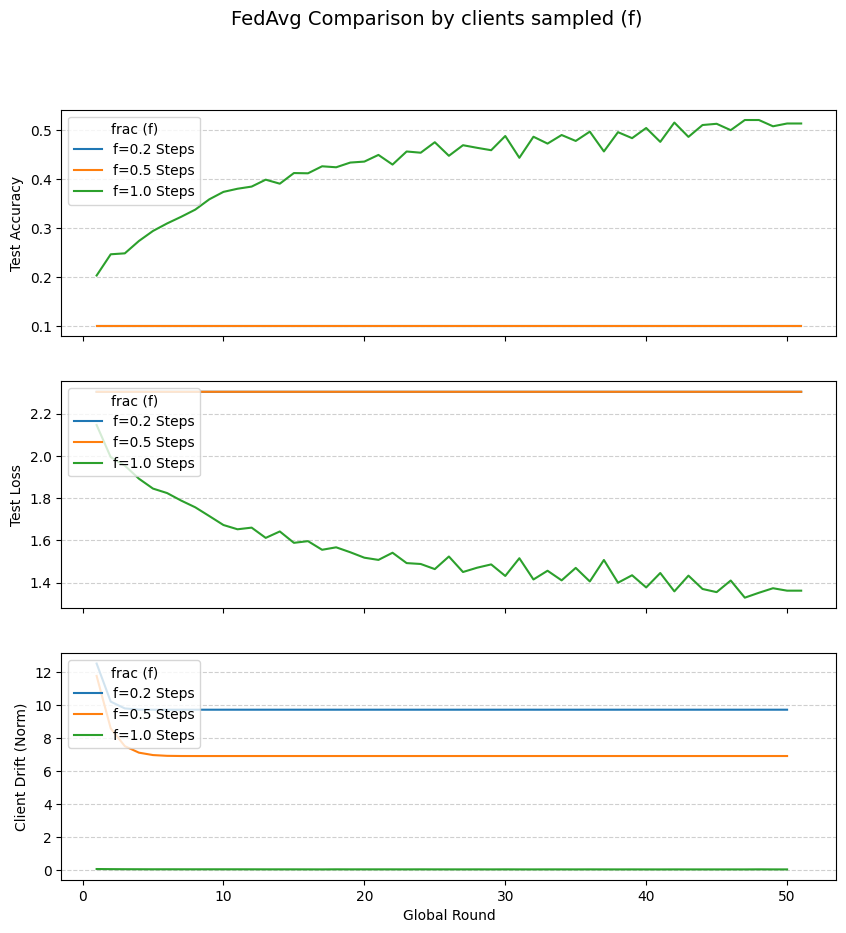

In [203]:
plot_metrics(metrics_exp_2)

In [ ]:
#experimental setup 3.
metrics_exp_3 = {}
for alpha in [0.01, 0.1,0.5,1,5, 10]: 
    f = fed_avg_exp(lr=3e-3, num_clients=5,num_steps=75, global_runs=25, alpha=alpha, sampling_frac=1)
    metrics_exp_3[k] = f.federated_method.round_metrics

In [ ]:
plot_metrics(metrics_exp_3)